In [ ]:
# Library Installation
!pip install yfinance numpy pandas datetime scikit-learn matplotlib fredapi scipy

In [1]:
# Initialize
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta, datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from fredapi import Fred
from scipy.optimize import minimize
from scipy import stats

np.set_printoptions(precision = 5, floatmode='fixed') # to ourput 5 decimal places
pd.set_option('display.precision', 5)

2023
[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed
Beta for AAPL: 1.22863
Beta for AMZN: 1.09696
Beta for BRK-B: 0.83997
Beta for GOOG: 1.13387
Beta for LLY: 0.64285
Beta for META: 1.28657
Beta for MSFT: 1.19397
Beta for NVDA: 1.72716
Beta for TSLA: 1.49715
Beta for V: 1.06094

Risk Free Rate: 0.04800
Expected Annual Market Return: 0.12026
Expected Annual Return for AAPL: 0.13678
Expected Annual Return for AMZN: 0.12726
Expected Annual Return for BRK-B: 0.10869
Expected Annual Return for GOOG: 0.12993
Expected Annual Return for LLY: 0.09445
Expected Annual Return for META: 0.14096
Expected Annual Return for MSFT: 0.13427
Expected Annual Return for NVDA: 0.17280
Expected Annual Return for TSLA: 0.15618
Expected Annual Return for V: 0.12466


Text(0, 0.5, 'Return')

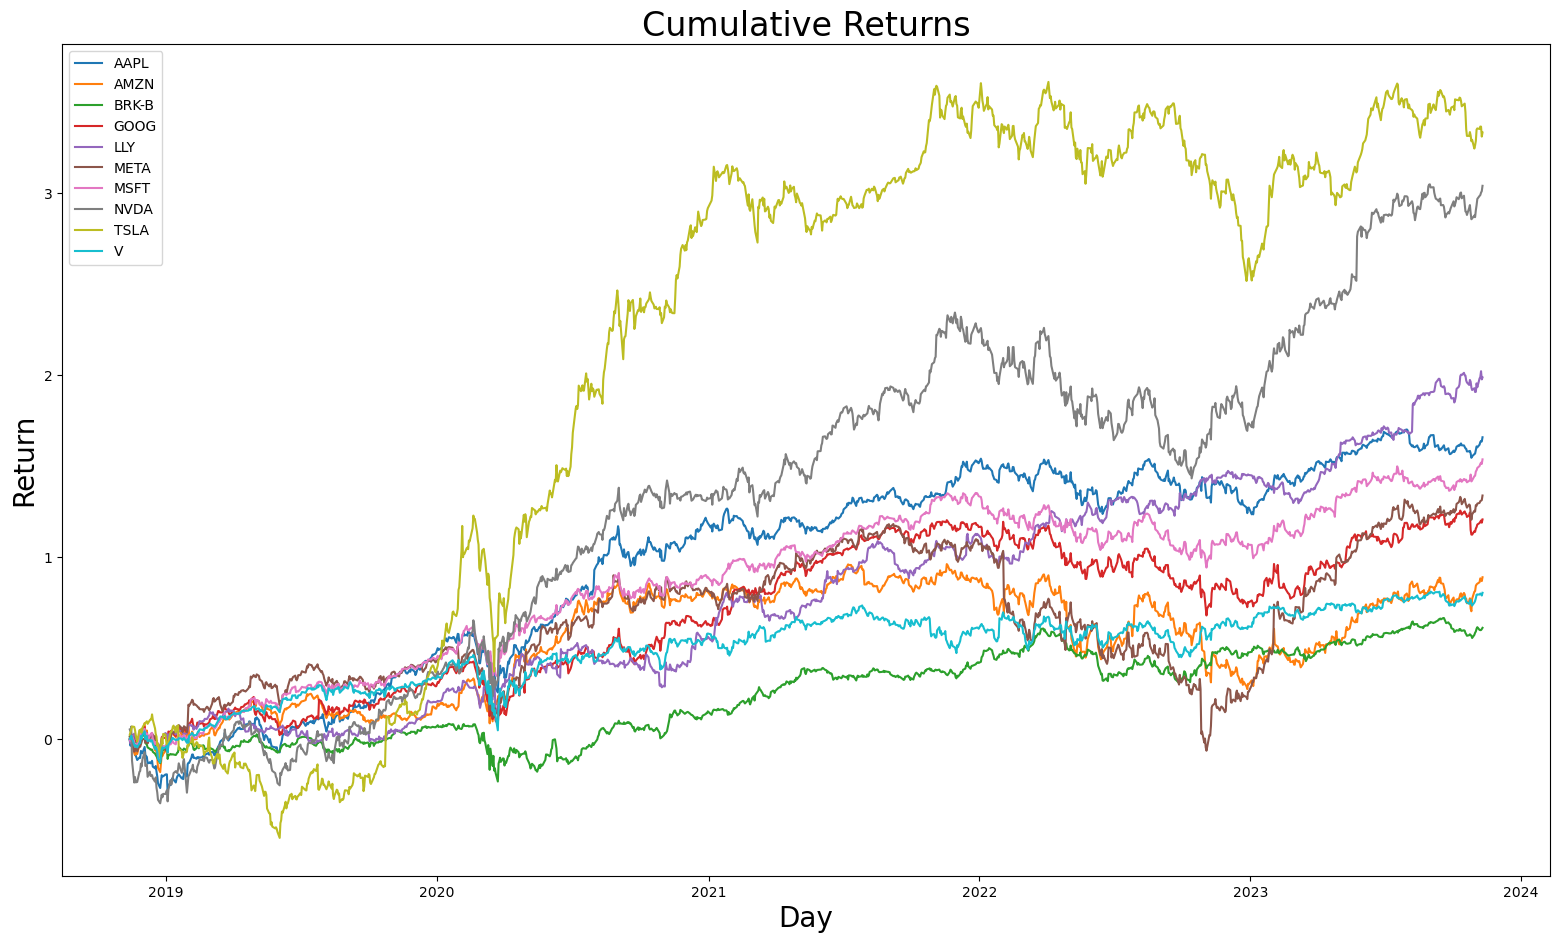

In [2]:
# CAPM regression for expected returns

# Preparation
def leap(x):
    n = 0
    year = end_date.year
    print(year)
    for i in range(x):
        if (year - i) % 4 == 0 and (year - i) % 100 != 0:
            n += 1
        if (year - i) % 100 == 0 and (year - i) % 400 == 0:
            n += 1
    return (x*365)+n

end_date = datetime.today() - timedelta(1)           
start_date = end_date - timedelta(leap(5))
stock_symbols = ["AAPL", "AMZN", "BRK-B", "GOOG", "LLY", "META", "MSFT", "NVDA", "TSLA", "V"] 
market_index = '^SPX' 
num_assets = len(stock_symbols)

data = yf.download(stock_symbols, start = start_date, end = end_date)
market_data = yf.download(market_index, start = start_date, end = end_date)
adj_data = pd.DataFrame(data['Adj Close'])
adj_market_data = pd.DataFrame(market_data['Adj Close'])

returns = adj_data.pct_change().dropna()
market_returns = adj_market_data.pct_change().dropna()


# Regression 
rmodel = LinearRegression()
x = market_returns.values.reshape(-1, 1)
y = returns.values
rmodel.fit(x, y)

stock_beta = rmodel.coef_.reshape(-1) # b0 = beta of 1st stock, b1 = beta of 2nd stock, etc.
line = rmodel.intercept_.reshape(-1)

for i in range(num_assets):
    print(f'Beta for {stock_symbols[i]}:', '{:.5f}'.format(stock_beta[i]))
print()


# Preparation for calculating expected returns
fred = Fred(api_key = '5f30d0ab3a11902af2b14f844a70e40f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100
risk_free_rate = ten_year_treasury_rate.iloc[-1]
print('Risk Free Rate:', '{:.5f}'.format(risk_free_rate))

# Calculating expected return for each asset
expected_market_return = np.sum(market_returns.mean() * 252)
print('Expected Annual Market Return:', '{:.5f}'.format(expected_market_return))
capm_expected_return = risk_free_rate + stock_beta * (expected_market_return - risk_free_rate)

for i in range(num_assets):
    print(f'Expected Annual Return for {stock_symbols[i]}:', '{:.5f}'.format(capm_expected_return[i]))
    
# Visualize cumulative return of each asset    
plt.figure(figsize = (19.2,10.8))
for i in range(num_assets):
    plt.plot(returns.iloc[:,i].cumsum(), label = stock_symbols[i])
plt.legend()
plt.title('Cumulative Returns', fontsize = 24)
plt.xlabel('Day', fontsize = 20)
plt.ylabel('Return', fontsize = 20)

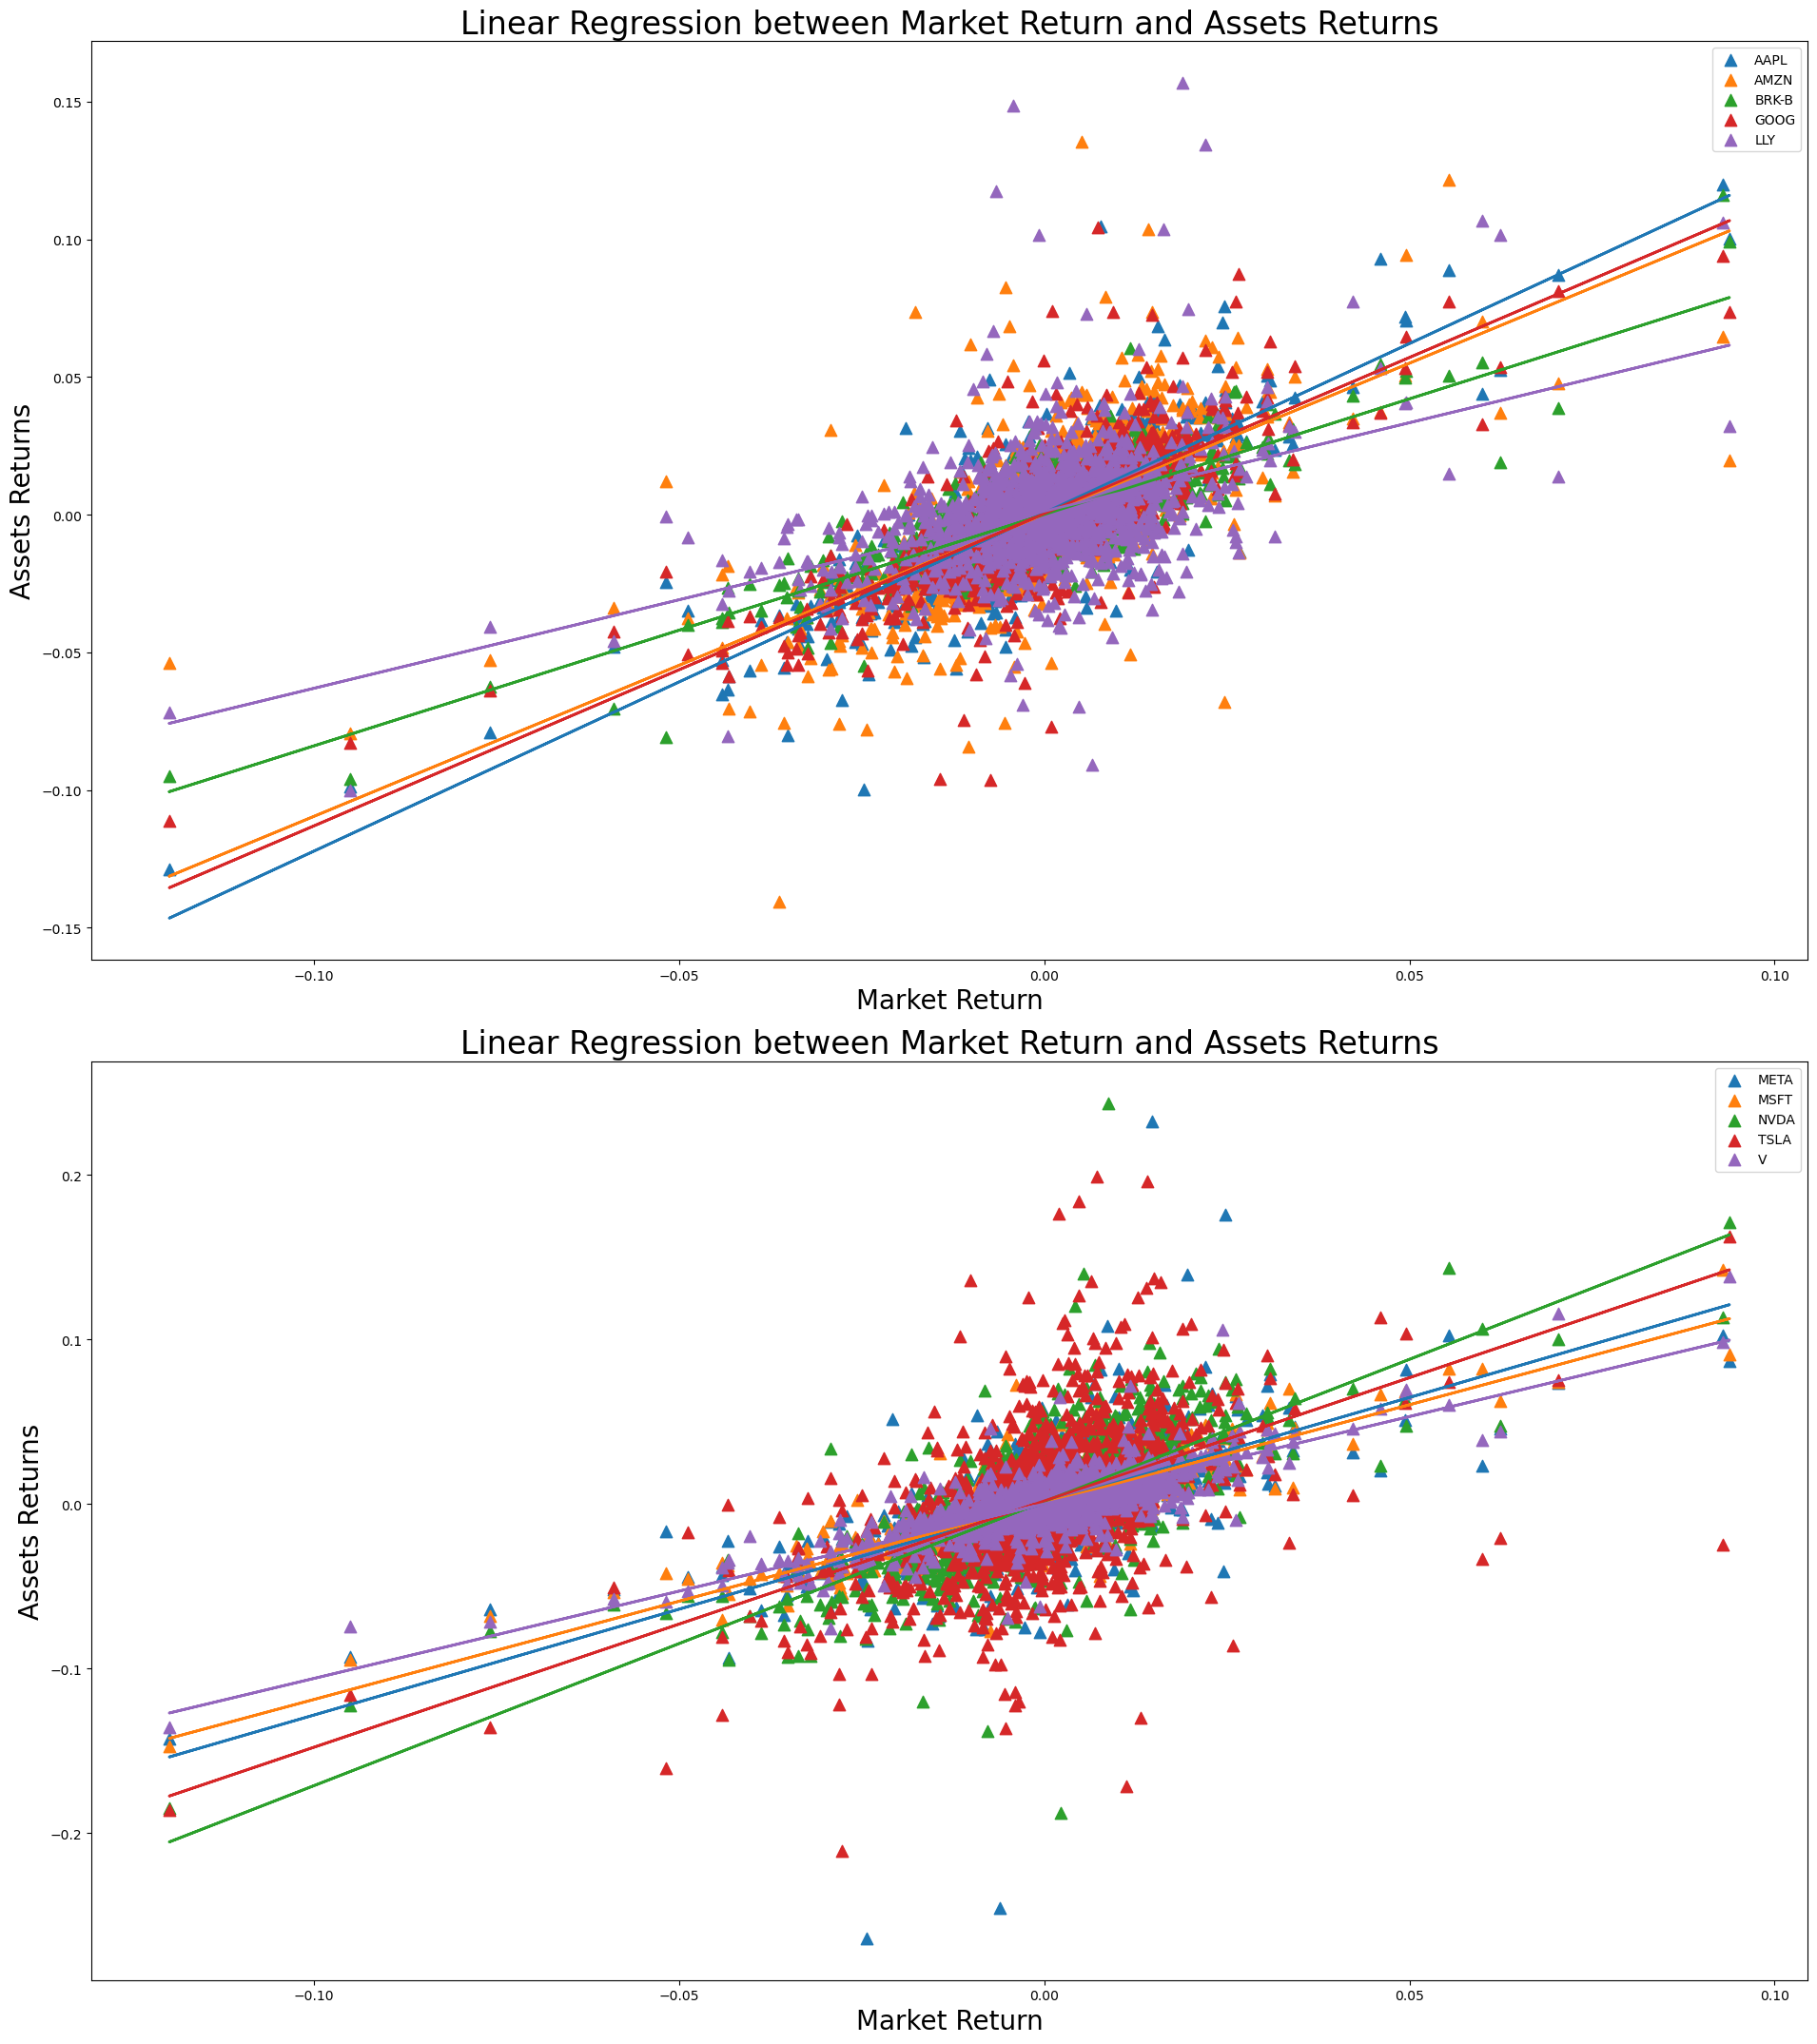

In [3]:
# Scatter plot shows relationship between assets returns and market return
fig, axes = plt.subplots(2, 1, figsize=(19.2,21.6))
for i in range(0, num_assets // 2):
    lin = line[i] 
    axes[0].scatter(x, y[:,i], s = 80,  marker = '^', label = stock_symbols[i])
    axes[0].plot(x, stock_beta[i] * x + lin, linewidth = 2)
for i in range(num_assets // 2, num_assets):
    lin = line[i] 
    axes[1].scatter(x, y[:,i], s = 80, marker = '^', label = stock_symbols[i]) 
    axes[1].plot(x, stock_beta[i] * x + lin, linewidth = 2)
for i in range(2):
    axes[i].set_xlabel('Market Return', fontsize = 20)
    axes[i].set_ylabel('Assets Returns', fontsize = 20)
    axes[i].set_title('Linear Regression between Market Return and Assets Returns', fontsize = 24)
    axes[i].legend() 

plt.tight_layout()
plt.show()

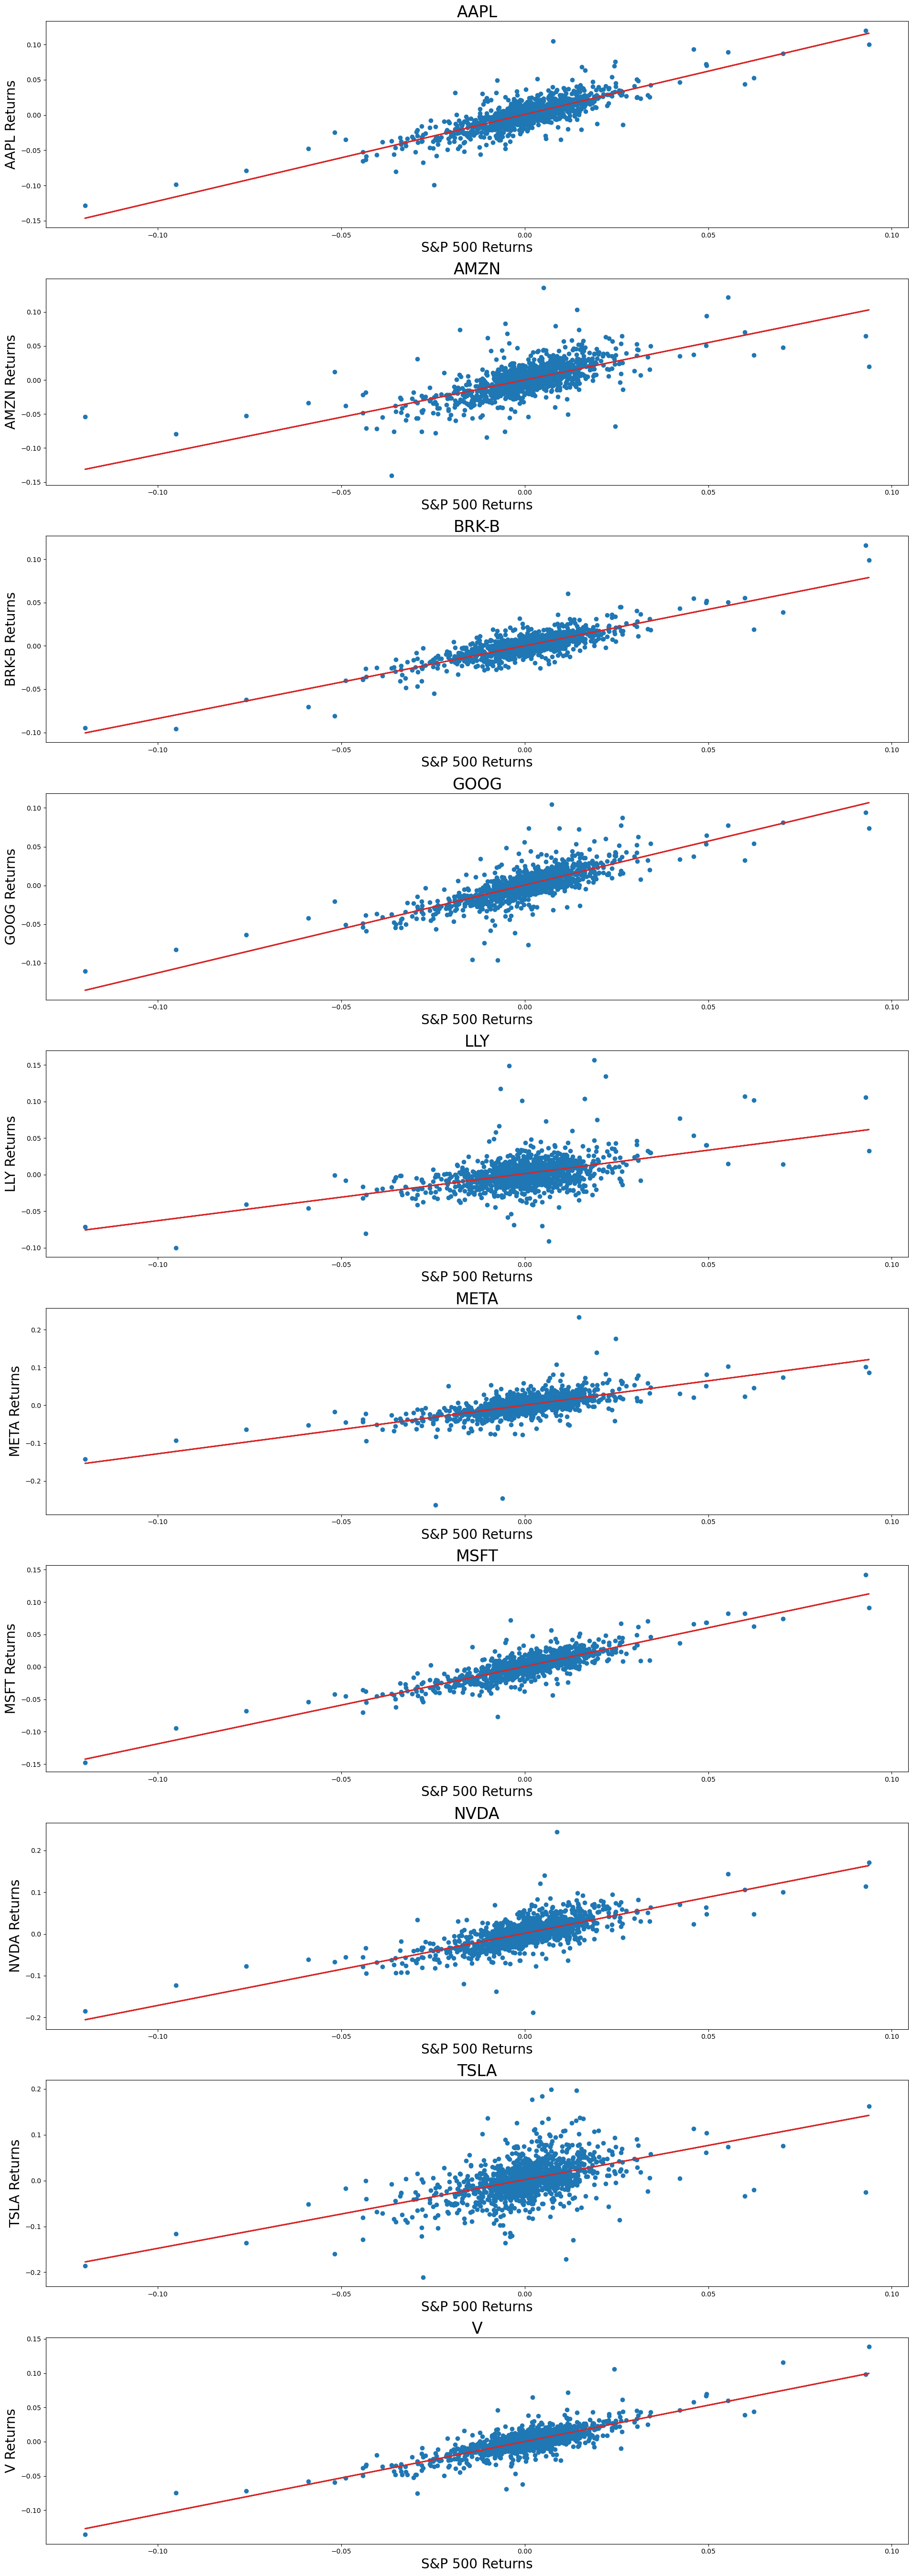

In [4]:
# Visualize regression results of each asset
num_rows = int(np.ceil(np.sqrt(num_assets)))
num_cols = int(np.ceil(num_assets / num_rows))
fig, axes = plt.subplots(num_assets, 1, figsize = (19.2, 54))

axes = axes.flatten() # flatten the axes array if it's not 2D

for i, var in enumerate(stock_symbols):
    lin = line[i] 
    axes[i].scatter(x, y[:,i], color = 'tab:blue')
    axes[i].plot(x, stock_beta[i] * x + lin, linewidth = 2, color = 'tab:red')
    axes[i].set_title(var, fontsize = 24)
    axes[i].set_ylabel(str(var) + ' Returns', fontsize = 20)
    axes[i].set_xlabel('S&P 500 Returns', fontsize = 20)
plt.tight_layout()
plt.show()

Optimal Weights: 
AAPL: 0.0940
AMZN: 0.0364
BRK-B: 0.3879
GOOG: 0.0583
LLY: 0.0569
META: 0.0251
MSFT: 0.1276
NVDA: 0.0434
TSLA: 0.0229
V: 0.1475

Expected Annual Return: 0.1227
Expected Volatility: 0.2320
Sharpe Ratio: 0.3221


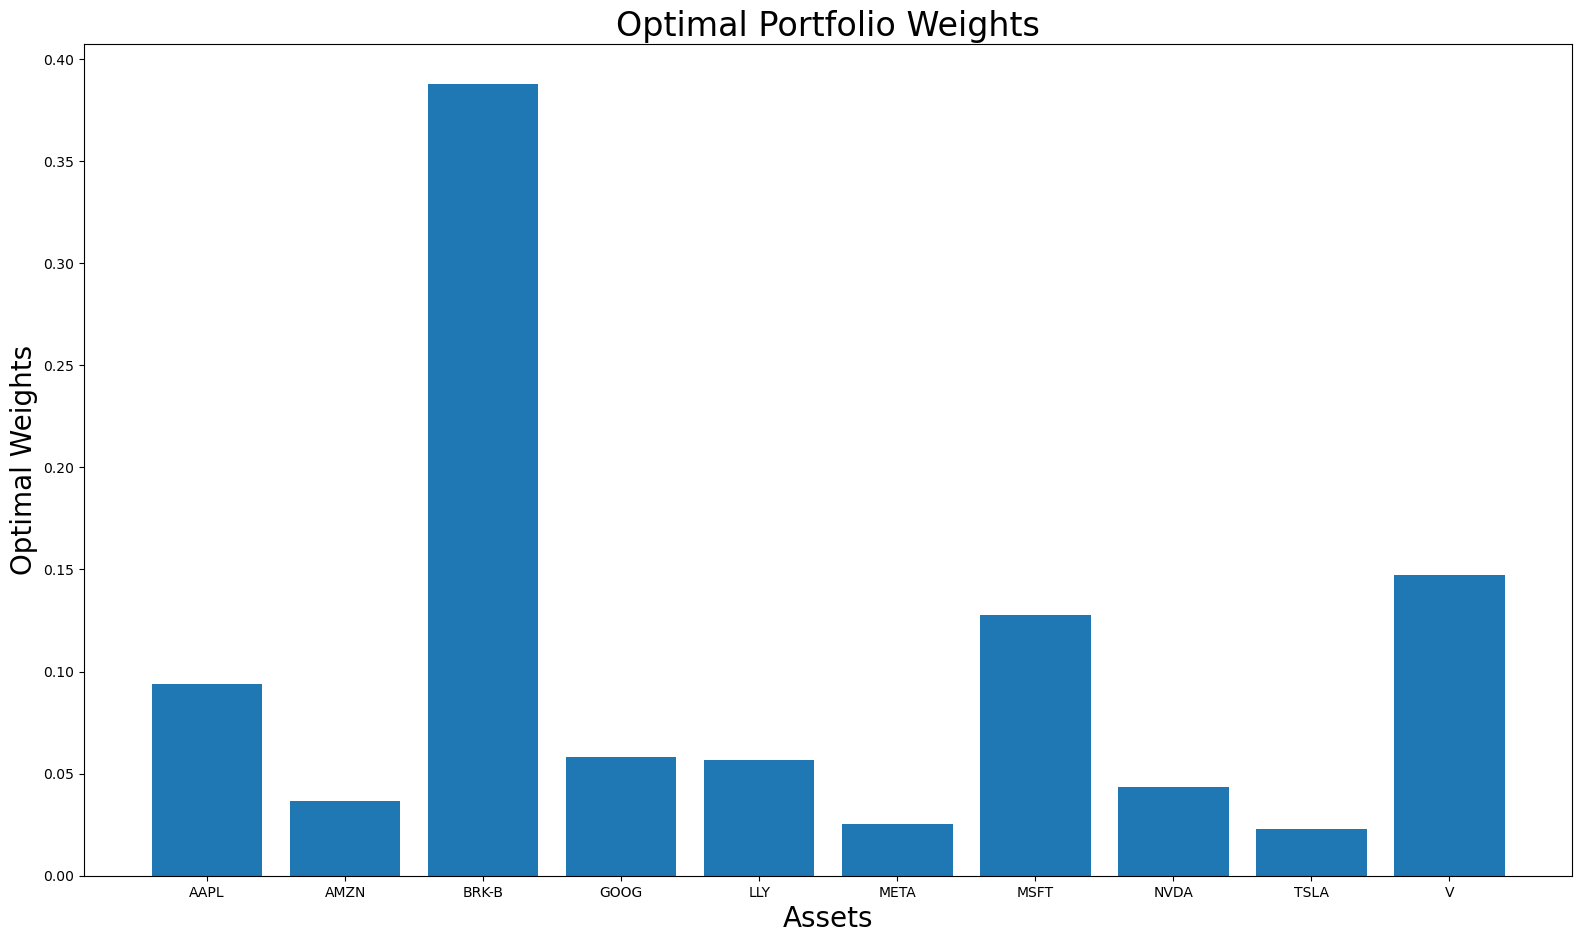

In [5]:
# Optimization
# Based on CAPM and regression
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights 
    return np.sqrt(variance)

def expected_return(weights): # key assumption: expected returns are calculated from CAPM model
    return np.sum(capm_expected_return.reshape(1, -1) @ weights.reshape(-1, 1)) 

def sharpe_ratio(weights, cov_matrix, risk_free_rate): 
    return (expected_return(weights) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, cov_matrix, risk_free_rate)

cov_matrix = returns.cov() * 252 
constraints = {'type': 'eq', 'fun':lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(num_assets)]
initial_weights = np.array([1 / num_assets] * num_assets)

optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(cov_matrix, risk_free_rate), method='SLSQP', 
                             constraints = constraints, bounds = bounds)
optimal_weights = np.array(optimized_results.x)
optimal_portfolio_return = expected_return(optimal_weights)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, cov_matrix, risk_free_rate)

print('Optimal Weights: ')
for ticker, weight in zip(stock_symbols, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
print()
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# Visualize portfolio weights in bar chart
plt.figure(figsize = (19.2, 10.8))
plt.bar(stock_symbols, optimal_weights)
plt.xlabel('Assets', fontsize = 20)
plt.ylabel('Optimal Weights', fontsize = 20)
plt.title('Optimal Portfolio Weights', fontsize = 24)
plt.show()

Optimal Weights: 
AAPL: 0.0940
AMZN: 0.0364
BRK-B: 0.3879
GOOG: 0.0583
LLY: 0.0569
META: 0.0251
MSFT: 0.1276
NVDA: 0.0434
TSLA: 0.0229
V: 0.1475

Expected Annual Return: 0.5061
Expected Volatility: 0.3140
Sharpe Ratio: 1.4591


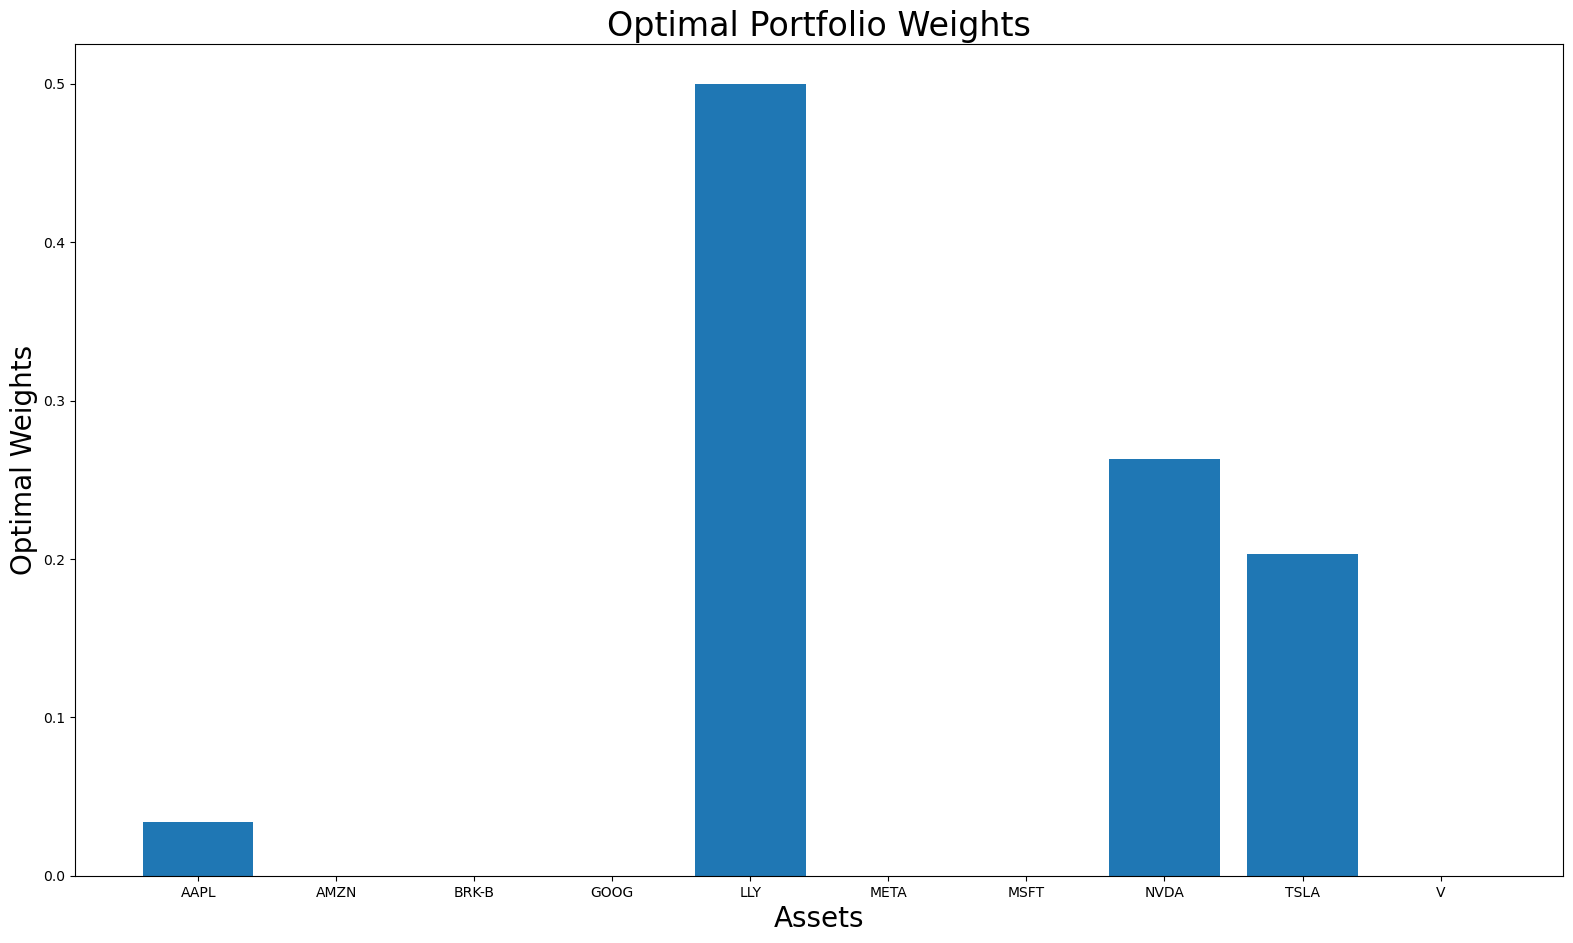

In [6]:
# Optimization
# Based on historical price of the assets

def h_expected_return(weights, returns): # key assumption: expected returns are based on historical returns
    return np.sum(returns.mean()*252 @ weights.reshape(-1,1)) # expected return of the investment

def h_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate): 
    return (h_expected_return(weights, returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def h_neg_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate):
    return -h_sharpe_ratio(weights, returns, cov_matrix, risk_free_rate)

optimized_results = minimize(h_neg_sharpe_ratio, initial_weights, args=(returns, cov_matrix, risk_free_rate), method='SLSQP', 
                             constraints = constraints, bounds=bounds)
h_optimal_weights = np.array(optimized_results.x)
h_optimal_portfolio_return = h_expected_return(h_optimal_weights, returns)
h_optimal_portfolio_volatility = standard_deviation(h_optimal_weights, cov_matrix)
h_optimal_sharpe_ratio = h_sharpe_ratio(h_optimal_weights, returns, cov_matrix, risk_free_rate)

print('Optimal Weights: ')
for ticker, weight in zip(stock_symbols, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
print()
print(f"Expected Annual Return: {h_optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {h_optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {h_optimal_sharpe_ratio:.4f}")

# Visualize portfolio weights in bar chart
plt.figure(figsize = (19.2, 10.8))
plt.bar(stock_symbols, h_optimal_weights)
plt.xlabel('Assets', fontsize = 20)
plt.ylabel('Optimal Weights', fontsize = 20)
plt.title('Optimal Portfolio Weights', fontsize = 24)
plt.show()

In [7]:
initial_investment = 1000000
print('Portfolio based on expected return from the CAPM and Simple Linear Regression')
perf = np.array([])
for i in range(num_assets):
    r = np.sum(returns.iloc[:,i] * optimal_weights[i])
    perf = np.append(perf, r)
print(f'Expected Portfolio Return (Day Trading): ' '{:,.2f}'.format((np.sum(perf)) * initial_investment))
perf2 = np.array([])
re = adj_data.iloc[-1]/adj_data.iloc[0] - 1
for i in range(num_assets):
    r = re[i] * optimal_weights[i]
    perf2 = np.append(perf2, r)   
print(f'Expected Portfolio Return (HODL): ' '{:,.2f}'.format((np.sum(perf2)) * initial_investment), '\n')

print('Portfolio based on expected return from the historical price')
h_perf = np.array([])
for i in range(num_assets):
    r = np.sum(returns.iloc[:,i] * h_optimal_weights[i])
    h_perf = np.append(h_perf, r)
print(f'Expected Portfolio Return (Day Trading): ' '{:,.2f}'.format((np.sum(h_perf)) * initial_investment))
h_perf2 = np.array([])
re = adj_data.iloc[-1]/adj_data.iloc[0] - 1
for i in range(num_assets):
    r = re[i] * h_optimal_weights[i]
    h_perf2 = np.append(h_perf2, r) 
print(f'Expected Portfolio Return (HODL): ' '{:,.2f}'.format((np.sum(h_perf2)) * initial_investment))

Portfolio based on expected return from the CAPM and Simple Linear Regression
Expected Portfolio Return (Day Trading): 1,163,932.79
Expected Portfolio Return (HODL): 2,010,362.50 

Portfolio based on expected return from the historical price
Expected Portfolio Return (Day Trading): 2,524,564.13
Expected Portfolio Return (HODL): 6,685,400.51
